In [2]:
# importando as bibliotecas necessarias

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import numpy as np
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import pandas as pd
import cartopy
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from scipy.stats import norm
from sklearn import datasets
import pandas_profiling as pdf
from functions import residuo

## 1) GRID

1.a) Incorporar os dados para o grid, do funcional gravity earth no icgem:<br>

In [5]:
# lendo arquivo do funcional gravity earth, para o grid

header=['Lon', 'Lat', 'H', 'g_abs']
gravity_earth=pd.read_csv('dados/gravity_earth.gdf',
                          sep='\s+',
                          skiprows=34,
                          names=header)
#------------------------------------------
# se for necessário corrigir a longitude:

Lon=np.array(gravity_earth['Lon'])
Long=np.zeros(len(gravity_earth))
for i in range (len(gravity_earth)):
    Long[i]=Lon[i]-360
gravity_earth['Lon']=Long
#-------------------------------------------

gravity_earth

Lon    Lat      H          g_abs
0      -50.50  -2.35   33.0  978027.210216
1      -50.47  -2.35   31.6  978028.780083
2      -50.44  -2.35   35.6  978029.353706
3      -50.41  -2.35   40.6  978029.761943
4      -50.38  -2.35   39.4  978031.852599
...       ...    ...    ...            ...
127597 -38.14 -11.50  196.4  978154.792663
127598 -38.11 -11.50  161.6  978173.657315
127599 -38.08 -11.50  141.6  978188.763343
127600 -38.05 -11.50  111.0  978208.264506
127601 -38.02 -11.50  167.4  978201.252830

[127602 rows x 4 columns]

1.b) Gerar um arquivo txt para carregar no MAPGEO2015 e gerar as ondulações geoidais do grid:<br>

In [4]:
# gerando uma copia do datafram para remover as colunas de altitude e gravidade, assim podendo exportar um txt com coordenadas somente

df = pd.DataFrame(gravity_earth, columns=['Lon', 'Lat', 'H', 'g_abs'])
df=df.drop('H', axis=1)
df=df.drop('g_abs', axis=1)

# usando o numpy para fugir do bug no pandas (problemas com a casa decimal):
np.savetxt('dados/formapgeo.txt',df,fmt='%10.4f')

1.c) Calcular a altitude ortométrica do grid:<br>

In [5]:
# lendo os valores de N calculados no MAPGEO2015 para calcular a altitude geométrica do grid

titulo=['N']
ondulacao=pd.read_csv('dados/ondulacao_geoidal_grid.txt',sep='\s+',decimal=b'.',names=titulo)

# Incorporando ao  dataframe do gravity_earth

N=np.array(ondulacao['N'])
gravity_earth['N']=N
gravity_earth

Lon    Lat      H          g_abs      N
0      -50.50  -2.35   33.0  978027.210216 -23.73
1      -50.47  -2.35   31.6  978028.780083 -23.74
2      -50.44  -2.35   35.6  978029.353706 -23.72
3      -50.41  -2.35   40.6  978029.761943 -23.68
4      -50.38  -2.35   39.4  978031.852599 -23.63
...       ...    ...    ...            ...    ...
127597 -38.14 -11.50  196.4  978154.792663 -12.06
127598 -38.11 -11.50  161.6  978173.657315 -11.81
127599 -38.08 -11.50  141.6  978188.763343 -11.54
127600 -38.05 -11.50  111.0  978208.264506 -11.30
127601 -38.02 -11.50  167.4  978201.252830 -11.05

[127602 rows x 5 columns]

In [6]:
# H é a altitude ortometrica, h é a altitude geométrica, N é a ondulação geoidal

H=np.array(gravity_earth['H'])
N=np.array(gravity_earth['N'])

h=np.array(H+N)

In [7]:
# incorporando os valores de h no dataframe

gravity_earth['h']=h
gravity_earth

Lon    Lat      H          g_abs      N       h
0      -50.50  -2.35   33.0  978027.210216 -23.73    9.27
1      -50.47  -2.35   31.6  978028.780083 -23.74    7.86
2      -50.44  -2.35   35.6  978029.353706 -23.72   11.88
3      -50.41  -2.35   40.6  978029.761943 -23.68   16.92
4      -50.38  -2.35   39.4  978031.852599 -23.63   15.77
...       ...    ...    ...            ...    ...     ...
127597 -38.14 -11.50  196.4  978154.792663 -12.06  184.34
127598 -38.11 -11.50  161.6  978173.657315 -11.81  149.79
127599 -38.08 -11.50  141.6  978188.763343 -11.54  130.06
127600 -38.05 -11.50  111.0  978208.264506 -11.30   99.70
127601 -38.02 -11.50  167.4  978201.252830 -11.05  156.35

[127602 rows x 6 columns]

1.d) Importar a função analítica da gravidade de (Li, Gotze 2001) e calcular a gravidade normal para o grid:<br>

In [8]:
# importando as funçoes de (Li,Gotze 2001) para ocalculo da gravidade normal, a partir da funcao pre definida 'grav_func.py', para o GRID

from functions.ellipsoid import WGS84
from functions.grav_func import gamma_closedform

In [9]:
# calculando a gravidade normal em relaçao ao elipsoide de referencia WGS84, para o grid

g_norm=gamma_closedform(gravity_earth['h'],gravity_earth['Lat'])

# incorporando os valores da gravidade normal ao dataframe

gravity_earth['g_norm']=g_norm
gravity_earth

Lon    Lat      H          g_abs      N       h         g_norm
0      -50.50  -2.35   33.0  978027.210216 -23.73    9.27  978038.351992
1      -50.47  -2.35   31.6  978028.780083 -23.74    7.86  978038.787369
2      -50.44  -2.35   35.6  978029.353706 -23.72   11.88  978037.546083
3      -50.41  -2.35   40.6  978029.761943 -23.68   16.92  978035.989847
4      -50.38  -2.35   39.4  978031.852599 -23.63   15.77  978036.344940
...       ...    ...    ...            ...    ...     ...            ...
127597 -38.14 -11.50  196.4  978154.792663 -12.06  184.34  978180.874500
127598 -38.11 -11.50  161.6  978173.657315 -11.81  149.79  978191.541400
127599 -38.08 -11.50  141.6  978188.763343 -11.54  130.06  978197.632879
127600 -38.05 -11.50  111.0  978208.264506 -11.30   99.70  978207.006396
127601 -38.02 -11.50  167.4  978201.252830 -11.05  156.35  978189.516065

[127602 rows x 7 columns]

1.e) Calcular o disturbio de gravidade para o grid:<br>

In [10]:
#Calculo do disturbio de gravidade, sendo delta =g_abs - g_norm, para o GRID

delta_grid=(np.array(gravity_earth['g_abs'])) - (np.array(gravity_earth['g_norm']))
delta_grid

array([-11.14177619, -10.0072857 ,  -8.19237665, ...,  -8.86953585,
         1.25810976,  11.7367657 ])

In [11]:
# Incorporar os valores de disturbio ao dataframe

gravity_earth['delta_g']=delta_grid
gravity_earth

Lon    Lat      H          g_abs      N       h         g_norm  \
0      -50.50  -2.35   33.0  978027.210216 -23.73    9.27  978038.351992   
1      -50.47  -2.35   31.6  978028.780083 -23.74    7.86  978038.787369   
2      -50.44  -2.35   35.6  978029.353706 -23.72   11.88  978037.546083   
3      -50.41  -2.35   40.6  978029.761943 -23.68   16.92  978035.989847   
4      -50.38  -2.35   39.4  978031.852599 -23.63   15.77  978036.344940   
...       ...    ...    ...            ...    ...     ...            ...   
127597 -38.14 -11.50  196.4  978154.792663 -12.06  184.34  978180.874500   
127598 -38.11 -11.50  161.6  978173.657315 -11.81  149.79  978191.541400   
127599 -38.08 -11.50  141.6  978188.763343 -11.54  130.06  978197.632879   
127600 -38.05 -11.50  111.0  978208.264506 -11.30   99.70  978207.006396   
127601 -38.02 -11.50  167.4  978201.252830 -11.05  156.35  978189.516065   

          delta_g  
0      -11.141776  
1      -10.007286  
2       -8.192377  
3       -6.227904  
4       -4.492341  
...           ...  
127597 -26.081837  
127598 -17.884084  
127599  -8.869536  
127600   1.258110  
127601  11.736766  

[127602 rows x 8 columns]

In [12]:
# exportando um unico arquivo txt com todos os parametros do grid devidademente processados

gravity_earth.to_csv('dados/grid_processado.txt',sep='\t',header=True)


## 2) Caminhamento terrestre

2.a) Incorporar os dados do caminhamento terrestre, que contem informaçoes de gravidade absoluta e altitude geometrica dos pontos:<br>

In [7]:
# lendo o arquivo do levantamento terrestre

terrestre=pd.read_csv('dados/Parnaiba_grav_survey.txt',sep=',', usecols=(0,7,16,17,19))
terrestre

Station  Elevation  Longitude  Latitude     Gravity
0          1    585.440   -39.9184   -5.4224  977923.454
1          2    610.596   -39.9278   -5.4199  977919.086
2          3    602.146   -39.9363   -5.4239  977921.063
3          4    620.888   -39.9444   -5.4231  977916.979
4          5    615.491   -39.9544   -5.4243  977918.161
..       ...        ...        ...       ...         ...
832      846    152.275   -49.2086   -5.3795  978010.654
833      847    127.972   -49.2300   -5.3855  978018.550
834      848    123.490   -49.2455   -5.3927  978020.448
835      849    120.395   -49.2638   -5.3921  978022.160
836      850    132.969   -49.2804   -5.3942  978021.430

[837 rows x 5 columns]

In [9]:
residuo.residuo(terrestre,terrestre_sat)
print(terrestre)

     Station  Elevation  Longitude  Latitude     Gravity  Normal_gravity  \
0          1    585.440   -39.9184   -5.4224  977923.454   977897.895710   
1          2    610.596   -39.9278   -5.4199  977919.086   977890.087948   
2          3    602.146   -39.9363   -5.4239  977921.063   977892.764180   
3          4    620.888   -39.9444   -5.4231  977916.979   977886.965200   
4          5    615.491   -39.9544   -5.4243  977918.161   977888.651532   
..       ...        ...        ...       ...         ...             ...   
832      846    152.275   -49.2086   -5.3795  978010.654   978030.898810   
833      847    127.972   -49.2300   -5.3855  978018.550   978038.503494   
834      848    123.490   -49.2455   -5.3927  978020.448   978040.008689   
835      849    120.395   -49.2638   -5.3921  978022.160   978040.954177   
836      850    132.969   -49.2804   -5.3942  978021.430   978037.107279   

         Delta   Residual  
0    25.558290  12.721669  
1    28.998052  16.486591  
2  

2.b) Calcular a gravidade normal pela formula analitica da gravidade de (Li, Gotze 2001)<br>

In [14]:
#calculando a gravidade normal para o caminhamento e incorporando ao DataFrame

g_norm_c=gamma_closedform(terrestre['Elevation'], terrestre['Latitude'])
terrestre['g_norm']=g_norm_c
terrestre

Station  Elevation  Longitude  Latitude     Gravity         g_norm
0          1    585.440   -39.9184   -5.4224  977923.454  977897.895710
1          2    610.596   -39.9278   -5.4199  977919.086  977890.087948
2          3    602.146   -39.9363   -5.4239  977921.063  977892.764180
3          4    620.888   -39.9444   -5.4231  977916.979  977886.965200
4          5    615.491   -39.9544   -5.4243  977918.161  977888.651532
..       ...        ...        ...       ...         ...            ...
832      846    152.275   -49.2086   -5.3795  978010.654  978030.898810
833      847    127.972   -49.2300   -5.3855  978018.550  978038.503494
834      848    123.490   -49.2455   -5.3927  978020.448  978040.008689
835      849    120.395   -49.2638   -5.3921  978022.160  978040.954177
836      850    132.969   -49.2804   -5.3942  978021.430  978037.107279

[837 rows x 6 columns]

2.c) Calcular os valores de disturbio predito (disturbio calculado com g medido por satelite) e distubio observado (disturbio calculado com g medido em campo:<br>

In [15]:
# Calculo do disturbio observado, este é o disurbio calculado a partir dos valores de gravidade fornecidos no caminhamento terrestre, e incorporando ao dataframe

delta_obs_c = (np.array(terrestre['Gravity'])) - (np.array(terrestre['g_norm']))
terrestre['delta_obs']=delta_obs_c
terrestre

Station  Elevation  Longitude  Latitude     Gravity         g_norm  \
0          1    585.440   -39.9184   -5.4224  977923.454  977897.895710   
1          2    610.596   -39.9278   -5.4199  977919.086  977890.087948   
2          3    602.146   -39.9363   -5.4239  977921.063  977892.764180   
3          4    620.888   -39.9444   -5.4231  977916.979  977886.965200   
4          5    615.491   -39.9544   -5.4243  977918.161  977888.651532   
..       ...        ...        ...       ...         ...            ...   
832      846    152.275   -49.2086   -5.3795  978010.654  978030.898810   
833      847    127.972   -49.2300   -5.3855  978018.550  978038.503494   
834      848    123.490   -49.2455   -5.3927  978020.448  978040.008689   
835      849    120.395   -49.2638   -5.3921  978022.160  978040.954177   
836      850    132.969   -49.2804   -5.3942  978021.430  978037.107279   

     delta_obs  
0    25.558290  
1    28.998052  
2    28.298820  
3    30.013800  
4    29.509468  
..         ...  
832 -20.244810  
833 -19.953494  
834 -19.560689  
835 -18.794177  
836 -15.677279  

[837 rows x 7 columns]

In [16]:
# Exportando um arquivo txt no formato  LAT, LON e ALT para input no ICGEM, e gerar a partir do funcional gravity os valores de gravidade preditos e porterior calculo de disturbio predito

terrestre.to_csv('dados/terrestre_input_icgem.txt',sep='\t',header=True, columns=['Latitude', 'Longitude', 'Elevation'])

In [6]:
# inportando os dados exportados do ICGEM, do funcional gravity, com informaçoes preditas por satélite para as coordenadas e altitudes do caminhamento

header=['Longitude', 'Latitude', 'Elevation', 'Gravity']
terrestre_sat=pd.read_csv('dados/output_icgem_caminhamento_predito.dat',skiprows=32, sep='\s+',decimal=b'.',names=header, usecols=(1,2,3,4))
terrestre_sat

Longitude  Latitude  Elevation        Gravity
0     -39.9184   -5.4224    585.440  977910.732331
1     -39.9278   -5.4199    610.596  977902.599409
2     -39.9363   -5.4239    602.146  977903.967536
3     -39.9444   -5.4231    620.888  977898.091663
4     -39.9544   -5.4243    615.491  977899.595192
..         ...       ...        ...            ...
832   -49.2086   -5.3795    152.275  977998.613184
833   -49.2300   -5.3855    127.972  978008.386942
834   -49.2455   -5.3927    123.490  978011.862785
835   -49.2638   -5.3921    120.395  978015.183335
836   -49.2804   -5.3942    132.969  978013.787418

[837 rows x 4 columns]

In [18]:
# nesta etapa vamos calcular a gravidade normal predita para posterior calculo do disturbio predito, e incorporar ao dataframe predito

g_norm_predito=gamma_closedform(terrestre_sat['h'], terrestre_sat['Lat'])
terrestre_sat['g_norm_pred']=g_norm_predito
terrestre_sat

Lon     Lat        h     g_abs_pred    g_norm_pred
0   -39.9184 -5.4224  585.440  977910.732331  977897.895710
1   -39.9278 -5.4199  610.596  977902.599409  977890.087948
2   -39.9363 -5.4239  602.146  977903.967536  977892.764180
3   -39.9444 -5.4231  620.888  977898.091663  977886.965200
4   -39.9544 -5.4243  615.491  977899.595192  977888.651532
..       ...     ...      ...            ...            ...
832 -49.2086 -5.3795  152.275  977998.613184  978030.898810
833 -49.2300 -5.3855  127.972  978008.386942  978038.503494
834 -49.2455 -5.3927  123.490  978011.862785  978040.008689
835 -49.2638 -5.3921  120.395  978015.183335  978040.954177
836 -49.2804 -5.3942  132.969  978013.787418  978037.107279

[837 rows x 5 columns]

In [19]:
# Calculo do Disturbio predito e incorporando ao dataframe predito

delta_pred_c = (np.array(terrestre_sat['g_abs_pred'])) - (np.array(terrestre_sat['g_norm_pred']))
terrestre_sat['delta_pred']=delta_pred_c
terrestre_sat

Lon     Lat        h     g_abs_pred    g_norm_pred  delta_pred
0   -39.9184 -5.4224  585.440  977910.732331  977897.895710   12.836621
1   -39.9278 -5.4199  610.596  977902.599409  977890.087948   12.511462
2   -39.9363 -5.4239  602.146  977903.967536  977892.764180   11.203355
3   -39.9444 -5.4231  620.888  977898.091663  977886.965200   11.126463
4   -39.9544 -5.4243  615.491  977899.595192  977888.651532   10.943661
..       ...     ...      ...            ...            ...         ...
832 -49.2086 -5.3795  152.275  977998.613184  978030.898810  -32.285626
833 -49.2300 -5.3855  127.972  978008.386942  978038.503494  -30.116552
834 -49.2455 -5.3927  123.490  978011.862785  978040.008689  -28.145904
835 -49.2638 -5.3921  120.395  978015.183335  978040.954177  -25.770842
836 -49.2804 -5.3942  132.969  978013.787418  978037.107279  -23.319861

[837 rows x 6 columns]

In [20]:
# Unificar em um unico data frame os dados preditos por satelite e os dados observados com o caminhamento

terrestre['g_abs_pred']=terrestre_sat['g_abs_pred']
terrestre['g_norm_pred']=terrestre_sat['g_norm_pred']
terrestre['delta_pred']=terrestre_sat['delta_pred']
terrestre

Station  Elevation  Longitude  Latitude     Gravity         g_norm  \
0          1    585.440   -39.9184   -5.4224  977923.454  977897.895710   
1          2    610.596   -39.9278   -5.4199  977919.086  977890.087948   
2          3    602.146   -39.9363   -5.4239  977921.063  977892.764180   
3          4    620.888   -39.9444   -5.4231  977916.979  977886.965200   
4          5    615.491   -39.9544   -5.4243  977918.161  977888.651532   
..       ...        ...        ...       ...         ...            ...   
832      846    152.275   -49.2086   -5.3795  978010.654  978030.898810   
833      847    127.972   -49.2300   -5.3855  978018.550  978038.503494   
834      848    123.490   -49.2455   -5.3927  978020.448  978040.008689   
835      849    120.395   -49.2638   -5.3921  978022.160  978040.954177   
836      850    132.969   -49.2804   -5.3942  978021.430  978037.107279   

     delta_obs     g_abs_pred    g_norm_pred  delta_pred  
0    25.558290  977910.732331  977897.895710   12.836621  
1    28.998052  977902.599409  977890.087948   12.511462  
2    28.298820  977903.967536  977892.764180   11.203355  
3    30.013800  977898.091663  977886.965200   11.126463  
4    29.509468  977899.595192  977888.651532   10.943661  
..         ...            ...            ...         ...  
832 -20.244810  977998.613184  978030.898810  -32.285626  
833 -19.953494  978008.386942  978038.503494  -30.116552  
834 -19.560689  978011.862785  978040.008689  -28.145904  
835 -18.794177  978015.183335  978040.954177  -25.770842  
836 -15.677279  978013.787418  978037.107279  -23.319861  

[837 rows x 10 columns]

2.d) Calcular os resíduos (R = DISTURBIO OBSERVADO - DISTURBIO PREDITO):<br>

In [21]:
# Calculo dos Residuos = Disturbio observado - disturbio predito, e incorporando ao dataframe

R=terrestre['delta_obs'] - terrestre['delta_pred']
terrestre['residuos']=R
terrestre

Station  Elevation  Longitude  Latitude     Gravity         g_norm  \
0          1    585.440   -39.9184   -5.4224  977923.454  977897.895710   
1          2    610.596   -39.9278   -5.4199  977919.086  977890.087948   
2          3    602.146   -39.9363   -5.4239  977921.063  977892.764180   
3          4    620.888   -39.9444   -5.4231  977916.979  977886.965200   
4          5    615.491   -39.9544   -5.4243  977918.161  977888.651532   
..       ...        ...        ...       ...         ...            ...   
832      846    152.275   -49.2086   -5.3795  978010.654  978030.898810   
833      847    127.972   -49.2300   -5.3855  978018.550  978038.503494   
834      848    123.490   -49.2455   -5.3927  978020.448  978040.008689   
835      849    120.395   -49.2638   -5.3921  978022.160  978040.954177   
836      850    132.969   -49.2804   -5.3942  978021.430  978037.107279   

     delta_obs     g_abs_pred    g_norm_pred  delta_pred   residuos  
0    25.558290  977910.732331  977897.895710   12.836621  12.721669  
1    28.998052  977902.599409  977890.087948   12.511462  16.486591  
2    28.298820  977903.967536  977892.764180   11.203355  17.095464  
3    30.013800  977898.091663  977886.965200   11.126463  18.887337  
4    29.509468  977899.595192  977888.651532   10.943661  18.565808  
..         ...            ...            ...         ...        ...  
832 -20.244810  977998.613184  978030.898810  -32.285626  12.040816  
833 -19.953494  978008.386942  978038.503494  -30.116552  10.163058  
834 -19.560689  978011.862785  978040.008689  -28.145904   8.585215  
835 -18.794177  978015.183335  978040.954177  -25.770842   6.976665  
836 -15.677279  978013.787418  978037.107279  -23.319861   7.642582  

[837 rows x 11 columns]

In [22]:
# Exportando um arquivo unico, final, com os dados para as aestaçoes terrestres, processados

terrestre.to_csv('dados/terrestre_porcessado.txt',sep='\t',header=True)

In [23]:
# lendo arquivo de satelite (com todas as etapas anteriores feitas, mas com os dados corretos de lat e lon)

sat=pd.read_csv('dados/Parnaiba_sat.txt', sep='\s+')
#sat.to_excel('dados/arquivo_sat_completo.xlsx',header=True)
sat

print(sat['Orthom'].min())
print(sat['Orthom'].max())

0.0
1322.92


In [24]:
sat


Longitude  Latitude  Orthom  Geoid_und    Geom           Gabs  \
0          -50.00     -0.20   10.00     -25.52  -15.52  978024.953868   
1          -49.97     -0.20   10.20     -25.55  -15.35  978025.648904   
2          -49.94     -0.20   13.00     -25.60  -12.60  978024.866424   
3          -49.91     -0.20   14.00     -25.66  -11.66  978023.189220   
4          -49.88     -0.20   11.40     -25.73  -14.33  978020.939292   
...           ...       ...     ...        ...     ...            ...   
135832     -39.62    -11.78  273.88     -11.50  262.38  978168.981579   
135833     -39.59    -11.78  267.08     -11.52  255.56  978171.814619   
135834     -39.56    -11.78  261.36     -11.55  249.81  978173.310386   
135835     -39.53    -11.78  258.72     -11.55  247.17  978173.747975   
135836     -39.50    -11.78  252.40     -11.54  240.86  978175.958914   

                Gnorm    Disturb  
0       978037.388780 -12.434910  
1       978037.336287 -11.687380  
2       978036.487137 -11.620710  
3       978036.196882 -13.007660  
4       978037.021330 -16.082040  
...               ...        ...  
135832  978166.757120   2.224460  
135833  978168.862616   2.952003  
135834  978170.637784   2.672602  
135835  978171.452819   2.295156  
135836  978173.400880   2.558034  

[135837 rows x 8 columns]

# 3) Mapas<br>

In [25]:
print(sat['Gabs'].min())
print(sat['Gabs'].max())

977811.884356
978184.2482319999


In [26]:
print(terrestre['Elevation'].min())
print(terrestre['Elevation'].max())

74.543
718.83


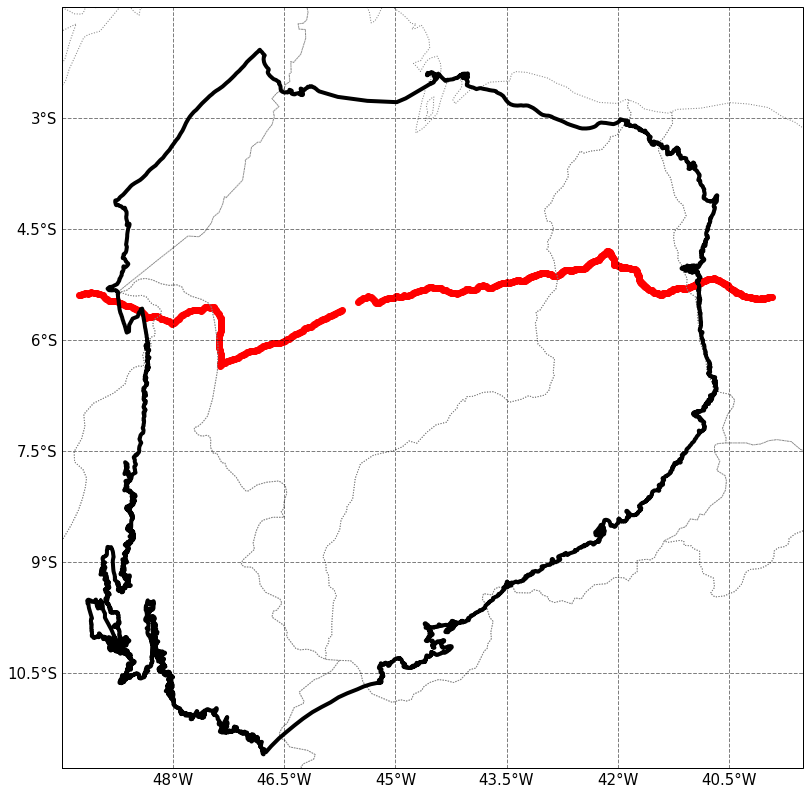

In [27]:
# Mapa da bacia do Parnaiba e as estaçoes do caminhamento

fig = plt.figure(figsize=(14,14))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_extent([-49.5, -39.5, -1.5, -11.78], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=1)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='black',alpha=0.5)

#adicionando o scatter com as informaçoes dos dataframes
f3=ax.scatter(terrestre['Longitude'], terrestre['Latitude'], color='red', transform=ccrs.PlateCarree())

#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

plt.savefig('imagens/bacia do parnaiba.png',format= 'png',dpi=300, bbox_inches='tight')
plt.show()

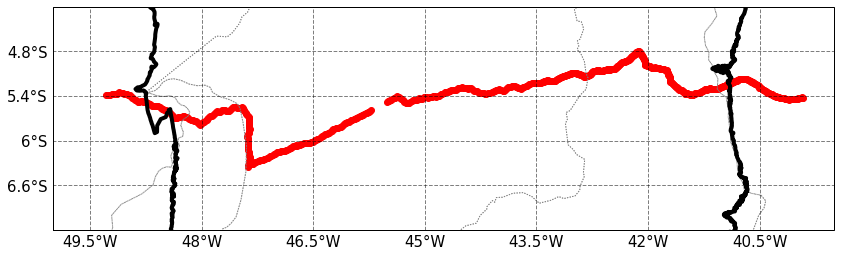

In [28]:
# Mapa da bacia do Parnaiba e as estaçoes do caminhamento

fig = plt.figure(figsize=(14,14))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50, -39.5, -4.2, -7.2], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=1)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='black',alpha=0.5)

#adicionando o scatter com as informaçoes dos dataframes
f3=ax.scatter(terrestre['Longitude'], terrestre['Latitude'], color='red', transform=ccrs.PlateCarree())

#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

plt.savefig('imagens/apresentaçao.png',format= 'png',dpi=300, bbox_inches='tight')
plt.show()

-26.82
1308.72


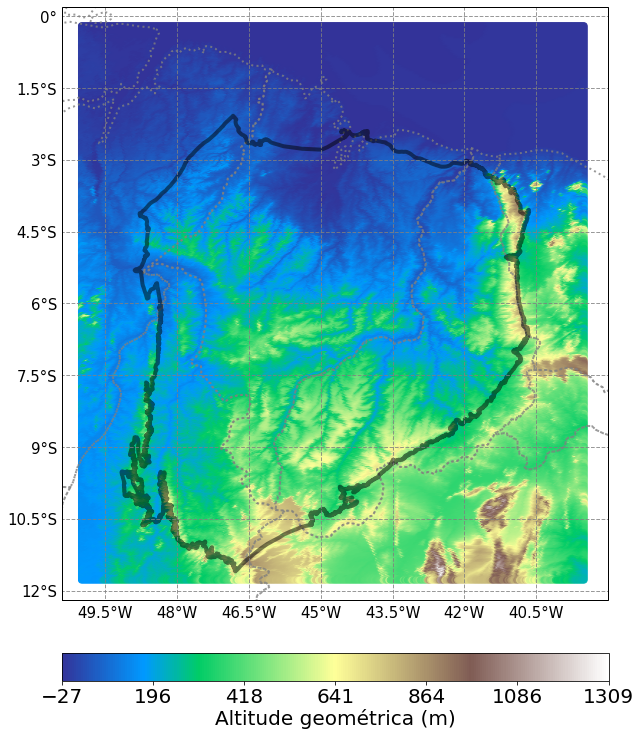

In [29]:
print(sat['Geom'].min())
print(sat['Geom'].max())

# Mapa de Altitude geométrica

fig = plt.figure(figsize=(14,14))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50.4,-39,-12.2,0.2], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.8)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)

#adicionando o scatter com as informaçoes dos dataframes
f2=ax.scatter(sat['Longitude'], sat['Latitude'],
              c=sat['Geom'],
              cmap='terrain',
              vmin=-27, vmax=1309,
              transform=ccrs.PlateCarree())


#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

v = np.linspace(-27, 1309, 7, endpoint=True)
cbar=plt.colorbar(f2,shrink=0.7,orientation='horizontal',pad=0.07,aspect=20, ticks=v)
cbar.ax.tick_params(labelsize=20,color='black',labelcolor='black')
cbar.set_label('Altitude geométrica (m)',fontsize=20,labelpad=2)



plt.savefig('imagens/altitude geometrica da bacia do parnaiba.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
print(sat)

        Longitude  Latitude  Orthom  Geoid_und    Geom           Gabs  \
0          -50.00     -0.20   10.00     -25.52  -15.52  978024.953868   
1          -49.97     -0.20   10.20     -25.55  -15.35  978025.648904   
2          -49.94     -0.20   13.00     -25.60  -12.60  978024.866424   
3          -49.91     -0.20   14.00     -25.66  -11.66  978023.189220   
4          -49.88     -0.20   11.40     -25.73  -14.33  978020.939292   
...           ...       ...     ...        ...     ...            ...   
135832     -39.62    -11.78  273.88     -11.50  262.38  978168.981579   
135833     -39.59    -11.78  267.08     -11.52  255.56  978171.814619   
135834     -39.56    -11.78  261.36     -11.55  249.81  978173.310386   
135835     -39.53    -11.78  258.72     -11.55  247.17  978173.747975   
135836     -39.50    -11.78  252.40     -11.54  240.86  978175.958914   

                Gnorm    Disturb  
0       978037.388780 -12.434910  
1       978037.336287 -11.687380  
2       978036.487

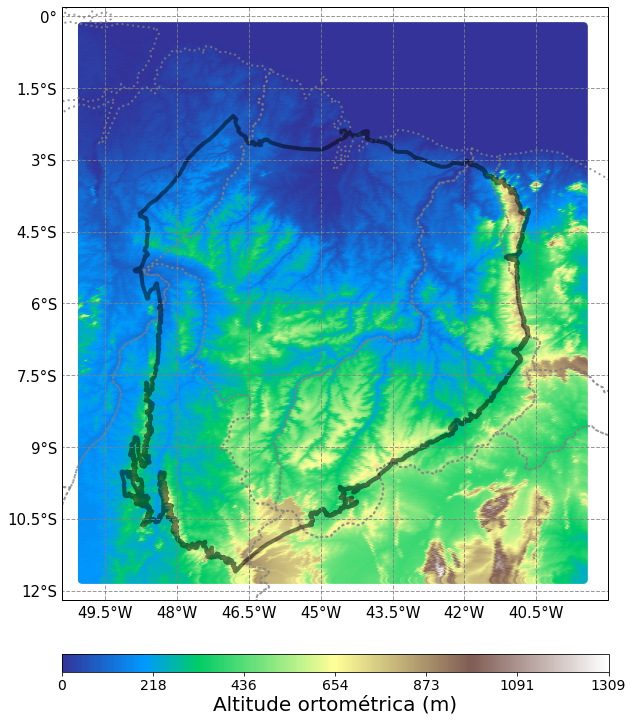

In [31]:
# Mapa de Altitude ortométrica

fig = plt.figure(figsize=(14,14))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50.4,-39,-12.2,0.2], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.8)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)

#adicionando o scatter com as informaçoes dos dataframes
f2=ax.scatter(sat['Longitude'], sat['Latitude'],
              c=sat['Orthom'],
              cmap='terrain',
              vmin=0, vmax=1309,
              transform=ccrs.PlateCarree())


#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

v = np.linspace(0, 1309, 7, endpoint=True)
cbar=plt.colorbar(f2,shrink=0.7,orientation='horizontal',pad=0.07,aspect=30, ticks=v)
cbar.ax.tick_params(labelsize=14,color='black',labelcolor='black')
cbar.set_label('Altitude ortométrica (m)',fontsize=20,labelpad=2)



plt.savefig('imagens/H.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

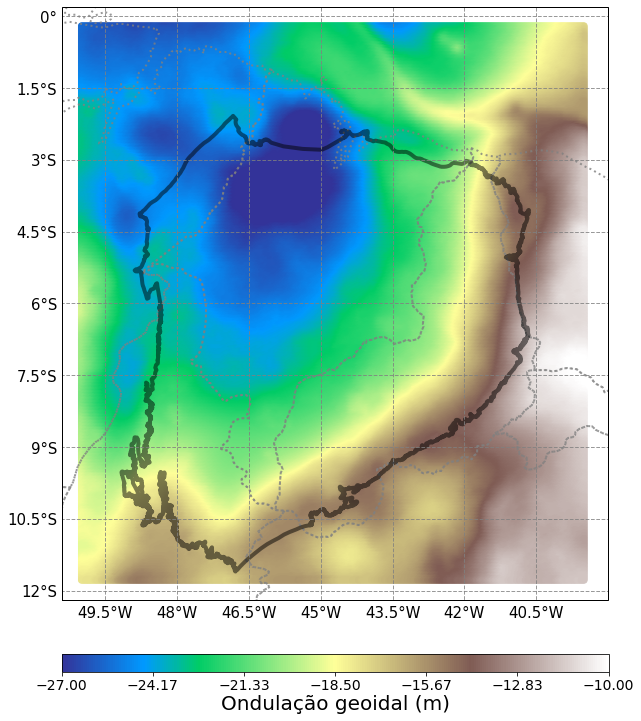

In [32]:
# Mapa de ondulaçao geoidal

fig = plt.figure(figsize=(14,14))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50.4,-39,-12.2,0.2], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.8)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)

#adicionando o scatter com as informaçoes dos dataframes
f2=ax.scatter(sat['Longitude'], sat['Latitude'],
              c=sat['Geoid_und'],
              cmap='terrain',
              vmin=-27, vmax=-10,
              transform=ccrs.PlateCarree())


#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

v = np.linspace(-27, -10, 7, endpoint=True)
cbar=plt.colorbar(f2,shrink=0.7,orientation='horizontal',pad=0.07,aspect=30, ticks=v)
cbar.ax.tick_params(labelsize=14,color='black',labelcolor='black')
cbar.set_label('Ondulação geoidal (m)',fontsize=20,labelpad=2)



plt.savefig('imagens/ond.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

977811.884356
978184.2482319999


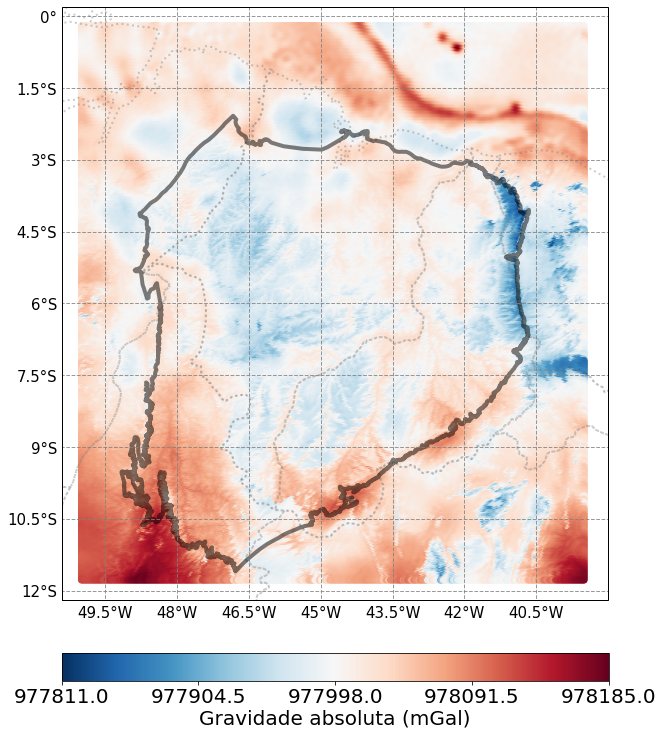

In [33]:
print(sat['Gabs'].min())
print(sat['Gabs'].max())
# Mapa de Gravidade absoluta

fig = plt.figure(figsize=(14,14))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # mportando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50.4,-39,-12.2,0.2], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.4)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)

#adicionando o scatter com as informaçoes dos dataframes
f2=ax.scatter(sat['Longitude'], sat['Latitude'],
              c=sat['Gabs'],
              cmap='RdBu_r',
              vmin=977811, vmax=978185,
              transform=ccrs.PlateCarree())

#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

v = np.linspace(977811, 978185, 5, endpoint=True)
cbar=plt.colorbar(f2,shrink=0.7,orientation='horizontal',pad=0.07,aspect=20, ticks=v)
cbar.set_label('Gravidade absoluta (mGal)',fontsize=20,labelpad=2)
cbar.ax.tick_params(labelsize=20,color='black',labelcolor='black')


plt.savefig('imagens/gravidade absoluta da bacia do parnaiba.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
gsomi = gamma_closedform(0.0, sat['Latitude'])

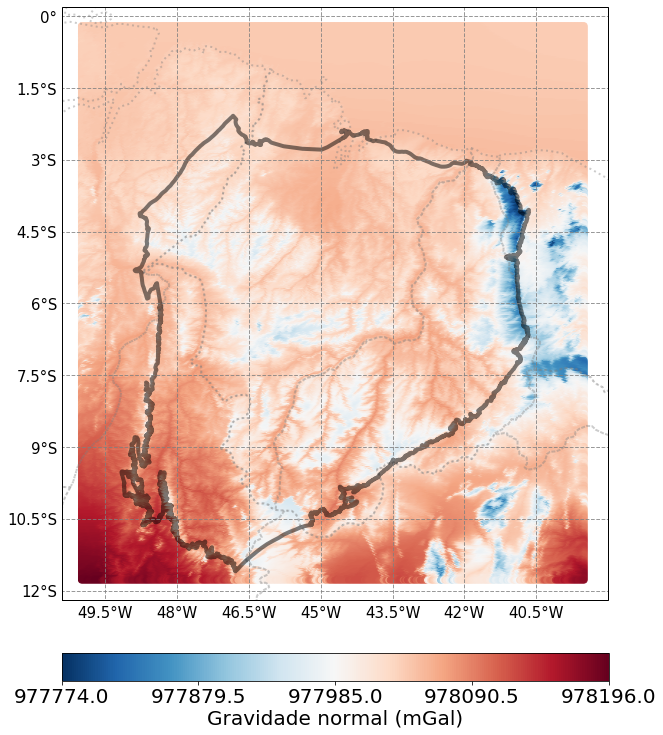

In [35]:

# Mapa de Gravidade normal

fig = plt.figure(figsize=(14,14))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50.4,-39,-12.2,0.2], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.4)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)

#adicionando o scatter com as informaçoes dos dataframes
f2=ax.scatter(sat['Longitude'], sat['Latitude'],
              c=sat.Gnorm,
              cmap='RdBu_r',
              vmin=977774, vmax=978196,
              transform=ccrs.PlateCarree())

#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)


v = np.linspace(977774, 978196, 5, endpoint=True)
cbar=plt.colorbar(f2,shrink=0.7,orientation='horizontal',pad=0.07,aspect=20, ticks=v)
cbar.set_label('Gravidade normal (mGal)',fontsize=20,labelpad=2)
cbar.ax.tick_params(labelsize=20,color='black',labelcolor='black')


plt.savefig('imagens/gravidade normal da bacia do parnaiba.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

-99.74985
144.6104


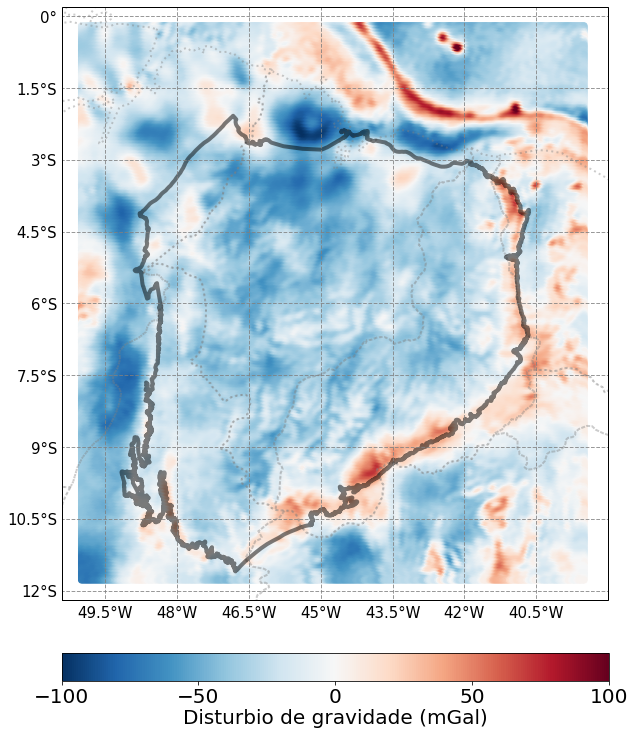

In [36]:
print(sat['Disturb'].min())
print(sat['Disturb'].max())
# Mapa de Disturbio

fig = plt.figure(figsize=(14,14))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50.4,-39,-12.2,0.2], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.4)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)
                  
#adicionando o scatter com as informaçoes dos dataframes
f2=ax.scatter(sat['Longitude'], sat['Latitude'],
              c=sat['Disturb'],
              cmap='RdBu_r',
              vmin=-100, vmax=100,
              transform=ccrs.PlateCarree())

#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

v = np.linspace(-100, 100, 5, endpoint=True)
cbar=plt.colorbar(f2,shrink=0.7,orientation='horizontal',pad=0.07,aspect=20, ticks=v)
cbar.set_label('Disturbio de gravidade (mGal)',fontsize=20,labelpad=2)
cbar.ax.tick_params(labelsize=20,color='black',labelcolor='black')
plt.savefig('imagens/disturbio da bacia do parnaiba.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

74.543
718.83


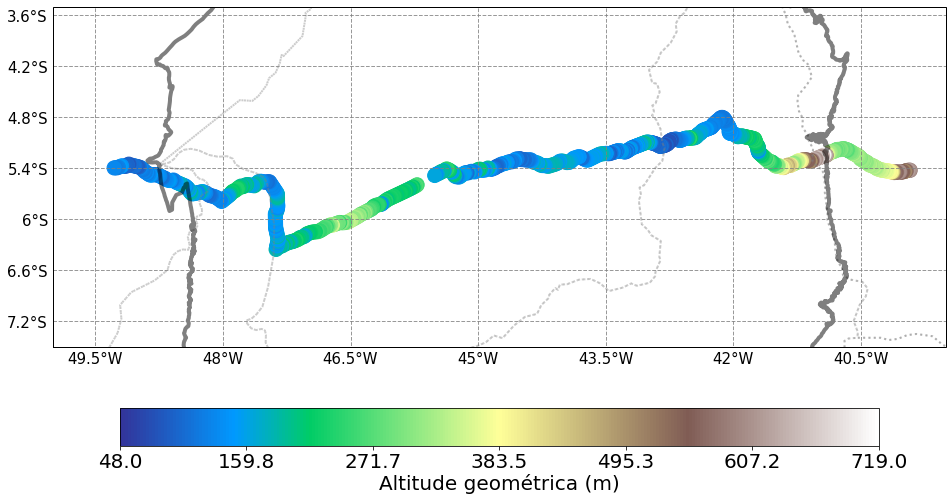

In [37]:
print(terrestre['Elevation'].min())
print(terrestre['Elevation'].max())

# Mapa de Altitude campo

fig = plt.figure(figsize=(16,16))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50, -39.5, -3.5, -7.5], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.4)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)

#adicionando o scatter com as informaçoes dos dataframes
f3=ax.scatter(terrestre['Longitude'], terrestre['Latitude'],
              c=terrestre['Elevation'], 
              s=200,
              cmap='terrain',
              vmin=48 ,vmax=719,
              transform=ccrs.PlateCarree())

#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20,y=1.02)

v = np.linspace(48, 719, 7, endpoint=True)

cbar=plt.colorbar(f3,shrink=0.85,orientation='horizontal',pad=0.07,aspect=20,ticks=v)
cbar.ax.tick_params(labelsize=20,color='black',labelcolor='black')
cbar.set_label('Altitude geométrica (m)',fontsize=20,labelpad=2)

plt.savefig('imagens/altitude geom campo.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

-26.82
1308.72
74.543
718.83


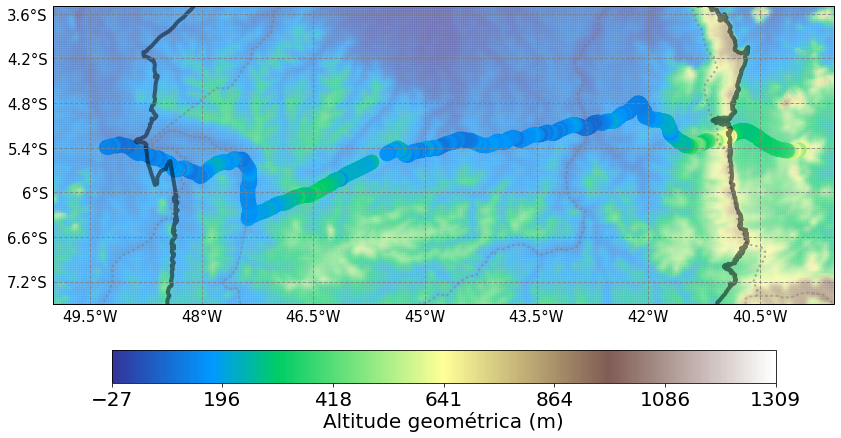

In [38]:
print(sat['Geom'].min())
print(sat['Geom'].max())
print(74.543)
print(718.83)

# Mapa de Altitude satelite x campo

fig = plt.figure(figsize=(14,12))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50, -39.5, -3.5, -7.5], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.4)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)

#adicionando o scatter com as informaçoes dos dataframes
f2=ax.scatter(sat['Longitude'], sat['Latitude'],
              c=sat['Geom'],
              cmap='terrain',
              vmin=-27,vmax=1309,
              alpha=0.1,
              transform=ccrs.PlateCarree())

f3=ax.scatter(terrestre['Longitude'], terrestre['Latitude'],
              c=terrestre['Elevation'],
              s=200,
              cmap='terrain',
              vmin=-27,vmax=1309,
              alpha=1,
              transform=ccrs.PlateCarree())

#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

v = np.linspace(-27, 1309, 7, endpoint=True)
cbar=plt.colorbar(f3,shrink=0.85,orientation='horizontal',pad=0.07,aspect=20, ticks=v)
cbar.set_label('Altitude geométrica (m)',fontsize=20,labelpad=2)
cbar.ax.tick_params(labelsize=20,color='black',labelcolor='black')

plt.savefig('imagens/altitude grid x campo.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

977811.884356
977893.4
978184.2482319999
978048.184


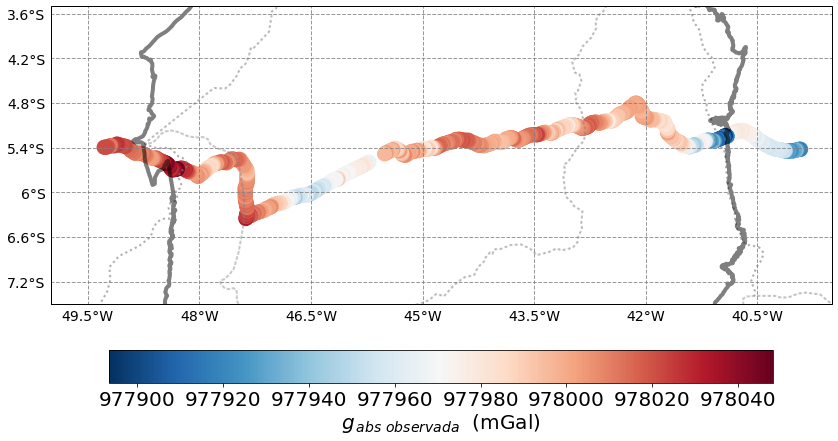

In [39]:
print(sat['Gabs'].min())
print(terrestre['Gravity'].min())
print(sat['Gabs'].max())
print(terrestre['Gravity'].max())

# Mapa de Gravidade absoluta satelite x caminhamento

fig = plt.figure(figsize=(14,12))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50, -39.5, -3.5, -7.5], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.4)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)

#adicionando o scatter com as informaçoes dos dataframes
#f2=ax.scatter(sat['Longitude'], sat['Latitude'],
 #             c=sat['Gabs'],
 #             cmap='RdBu_r',
  #            vmin=977811,vmax=978185,
   #           alpha=0.1,
    #          transform=ccrs.PlateCarree())

f3=ax.scatter(terrestre['Longitude'], terrestre['Latitude'],
              s=200,
              c=terrestre['Gravity'], 
              cmap='RdBu_r', 
              transform=ccrs.PlateCarree())

#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 14}
g1.ylabel_style = {'size': 14}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

v = np.linspace(977900 ,978040, 7, endpoint=True)
cbar=plt.colorbar(f3,shrink=0.85,orientation='horizontal',pad=0.07,aspect=20)
cbar.set_label('$g_{\,abs \,\, observada}$  (mGal)',fontsize=20,labelpad=2)
cbar.ax.tick_params(labelsize=20,color='black',labelcolor='black')

plt.savefig('imagens/ga_obs.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
terrestre

Station  Elevation  Longitude  Latitude     Gravity         g_norm  \
0          1    585.440   -39.9184   -5.4224  977923.454  977897.895710   
1          2    610.596   -39.9278   -5.4199  977919.086  977890.087948   
2          3    602.146   -39.9363   -5.4239  977921.063  977892.764180   
3          4    620.888   -39.9444   -5.4231  977916.979  977886.965200   
4          5    615.491   -39.9544   -5.4243  977918.161  977888.651532   
..       ...        ...        ...       ...         ...            ...   
832      846    152.275   -49.2086   -5.3795  978010.654  978030.898810   
833      847    127.972   -49.2300   -5.3855  978018.550  978038.503494   
834      848    123.490   -49.2455   -5.3927  978020.448  978040.008689   
835      849    120.395   -49.2638   -5.3921  978022.160  978040.954177   
836      850    132.969   -49.2804   -5.3942  978021.430  978037.107279   

     delta_obs     g_abs_pred    g_norm_pred  delta_pred   residuos  
0    25.558290  977910.732331  977897.895710   12.836621  12.721669  
1    28.998052  977902.599409  977890.087948   12.511462  16.486591  
2    28.298820  977903.967536  977892.764180   11.203355  17.095464  
3    30.013800  977898.091663  977886.965200   11.126463  18.887337  
4    29.509468  977899.595192  977888.651532   10.943661  18.565808  
..         ...            ...            ...         ...        ...  
832 -20.244810  977998.613184  978030.898810  -32.285626  12.040816  
833 -19.953494  978008.386942  978038.503494  -30.116552  10.163058  
834 -19.560689  978011.862785  978040.008689  -28.145904   8.585215  
835 -18.794177  978015.183335  978040.954177  -25.770842   6.976665  
836 -15.677279  978013.787418  978037.107279  -23.319861   7.642582  

[837 rows x 11 columns]

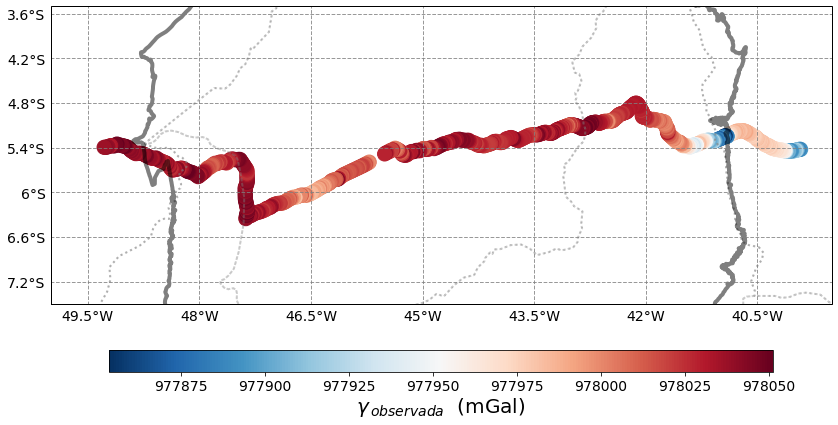

In [41]:
# Mapa de Gravidade normal caminhamento

fig = plt.figure(figsize=(14,12))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50, -39.5, -3.5, -7.5], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.4)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)

#adicionando o scatter com as informaçoes dos dataframes
#f2=ax.scatter(sat['Longitude'], sat['Latitude'],
 #             c=sat['Gabs'],
 #             cmap='RdBu_r',
  #            vmin=977811,vmax=978185,
   #           alpha=0.1,
    #          transform=ccrs.PlateCarree())

f3=ax.scatter(terrestre['Longitude'], terrestre['Latitude'],
              s=200,
              c=terrestre['g_norm'], 
              cmap='RdBu_r', 
              transform=ccrs.PlateCarree())

#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 14}
g1.ylabel_style = {'size': 14}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

#v = np.linspace(977811 ,978185, 7, endpoint=True)
cbar=plt.colorbar(f3,shrink=0.85,orientation='horizontal',pad=0.07,aspect=30)
cbar.set_label('$\gamma_{\,observada}$  (mGal)',fontsize=20,labelpad=2)
cbar.ax.tick_params(labelsize=14,color='black',labelcolor='black')

plt.savefig('imagens/gn_obs.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

-56.22877710452303
-51.773882184759714
27.401092541986145
39.70767975691706


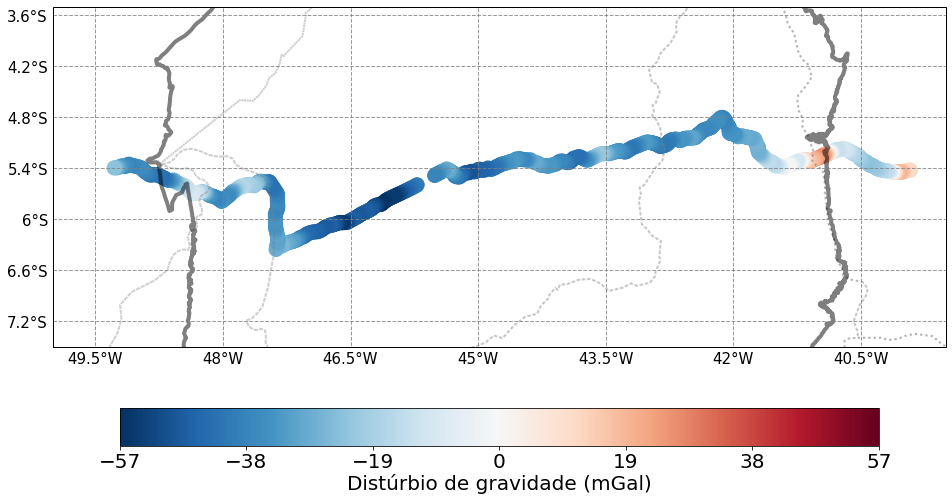

In [42]:
print(terrestre['delta_pred'].min())
print(terrestre['delta_obs'].min())
print(terrestre['delta_pred'].max())
print(terrestre['delta_obs'].max())

# Mapa dos disturbios preditos

fig = plt.figure(figsize=(16,16))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50, -39.5, -3.5, -7.5], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.4)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)

#adicionando o scatter com as informaçoes dos dataframes
f3=ax.scatter(terrestre['Longitude'], terrestre['Latitude'],
              c=terrestre['delta_pred'],
              s=200, 
              cmap='RdBu_r',
              vmin=-57,vmax=57,
              transform=ccrs.PlateCarree())
              
#removendo os eixos do lado direito e de cima
g1.ylabels_right = False  
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

v = np.linspace(-57, 57, 7, endpoint=True)
cbar=plt.colorbar(f3, shrink=0.85,orientation='horizontal',pad=0.07,aspect=20,ticks=v)
cbar.ax.tick_params(labelsize=20,color='black',labelcolor='black')
cbar.set_label('Distúrbio de gravidade (mGal)',fontsize=20,labelpad=2)

plt.savefig('imagens/perfil disturbio predito.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

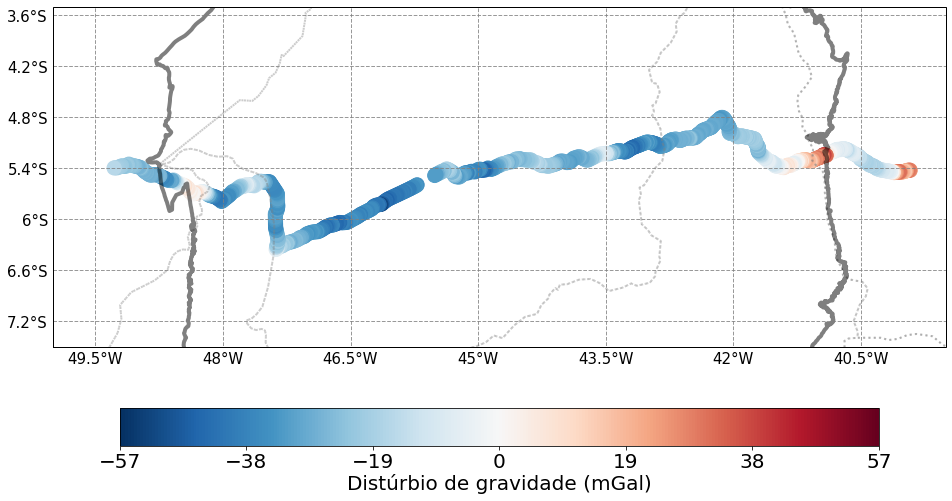

In [43]:
# Mapa dos disturbios observados

fig = plt.figure(figsize=(16,16))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50, -39.5, -3.5, -7.5], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.4)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)

#adicionando o scatter com as informaçoes dos dataframes
f3=ax.scatter(terrestre['Longitude'], terrestre['Latitude'], c=terrestre['delta_obs'], 
              s=200, 
              cmap='RdBu_r', 
              vmin=-57,vmax=57,
              transform=ccrs.PlateCarree())

#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

v = np.linspace(-57, 57, 7, endpoint=True)
cbar=plt.colorbar(f3, shrink=0.85,orientation='horizontal',pad=0.07,aspect=20,ticks=v)
cbar.ax.tick_params(labelsize=20,color='black',labelcolor='black')
cbar.set_label('Distúrbio de gravidade (mGal)',fontsize=20,labelpad=2)

plt.savefig('imagens/perfil disturbio observado.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

-7.20790650008712
22.413754800101742


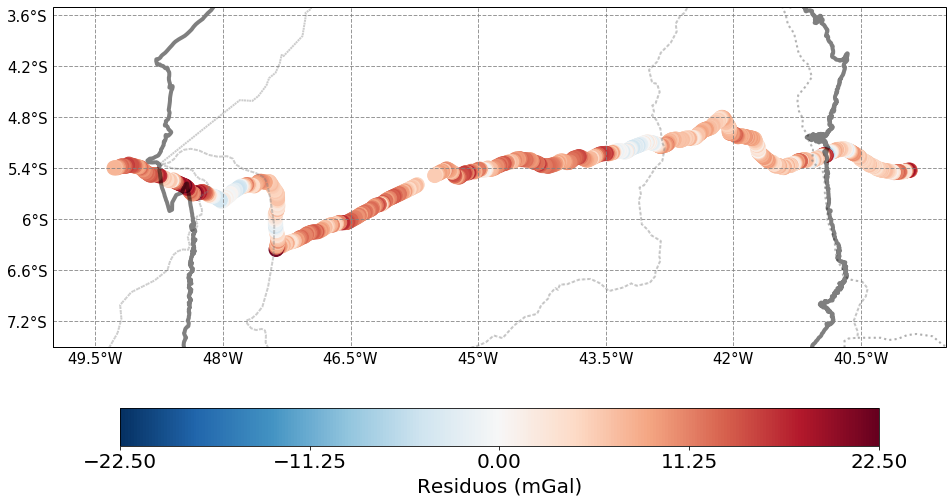

In [44]:
print(terrestre['residuos'].min())
print(terrestre['residuos'].max())

# Mapa dos residuos (disturbios observados - preditos)

fig = plt.figure(figsize=(16,16))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50, -39.5, -3.5, -7.5], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.4)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)

#adicionando o scatter com as informaçoes dos dataframes

#f4=ax.scatter(sat['Longitude'], sat['Latitude'], c=sat['Geom'], cmap='terrain', transform=ccrs.PlateCarree(),alpha=0.43)
f3=ax.scatter(terrestre['Longitude'], terrestre['Latitude'],
              c=terrestre['residuos'],
              s=200,
              vmin=-22.5,vmax=22.5,
              cmap='RdBu_r', transform=ccrs.PlateCarree())

#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

v = np.linspace(-22.5, 22.5, 5, endpoint=True)
cbar=plt.colorbar(f3, shrink=0.85,orientation='horizontal',pad=0.07,aspect=20,ticks=v)
cbar.ax.tick_params(labelsize=20,color='black',labelcolor='black')
cbar.set_label('Residuos (mGal)',fontsize=20,labelpad=5)

plt.savefig('imagens/perfil residuos.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

-70
-51.773882184759714
70
39.70767975691706


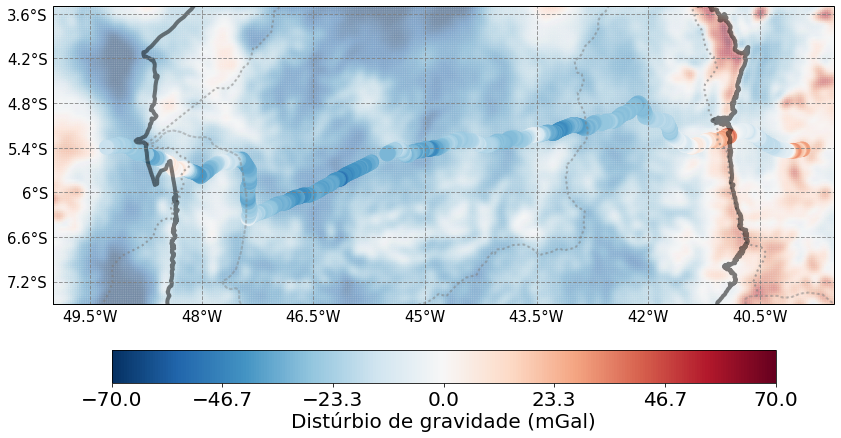

In [45]:
print(-70)
print(terrestre['delta_obs'].min())
print(70)
print(terrestre['delta_obs'].max())

# Mapa de Gravidade disturbios satelite x caminhamento

fig = plt.figure(figsize=(14,12))

fname='shape_bacia_do_parnaiba/bacia_parnaiba.shp' # importando o shape da bacia do parnaiba

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#feiçoes
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([-50, -39.5, -3.5, -7.5], ccrs.PlateCarree())

#determinando limite dos estados
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')

#adicionando a feicao dos estados
ax.add_feature(states, edgecolor='gray',linestyle=':', linewidth=2,alpha=0.4)

#adicionando a geometria do shape da bacia do parnaiba
ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),facecolor='none',edgecolor='black', linewidth=4,alpha=0.5)

#adicionando linhas de grade
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1,color='gray',alpha=0.8)

#adicionando o scatter com as informaçoes dos dataframes
f2=ax.scatter(sat['Longitude'], sat['Latitude'],
              c=sat['Disturb'],
              cmap='RdBu_r',
              vmin=-70,vmax=70,
              alpha=0.07,
              transform=ccrs.PlateCarree())

f3=ax.scatter(terrestre['Longitude'], terrestre['Latitude'],
              s=200,
              c=terrestre['delta_obs'], 
              cmap='RdBu_r', 
              vmin=-70,vmax=70,
              alpha=1.0,
              transform=ccrs.PlateCarree())

#removendo os eixos do lado direito e de cima
g1.ylabels_right = False
g1.xlabels_top = False

#formatando os eixos para georreferenciar
g1.yformatter = LATITUDE_FORMATTER
g1.xformatter = LONGITUDE_FORMATTER

g1.xlabel_style = {'size': 15}
g1.ylabel_style = {'size': 15}
#ax.set_title('Bacia do Parnaíba', fontsize=20, y=1.02)

v = np.linspace(-70 ,70, 7, endpoint=True)
cbar=plt.colorbar(f3,shrink=0.85,orientation='horizontal',pad=0.07,aspect=20, ticks=v)
cbar.set_label('Distúrbio de gravidade (mGal)',fontsize=20,labelpad=2)
cbar.ax.tick_params(labelsize=20,color='black',labelcolor='black')

plt.savefig('imagens/disturbio obs X pred.png',format='png', dpi=300, bbox_inches='tight')
plt.show()

In [46]:

ndat = len(terrestre.residuos)
mean = terrestre['residuos'].mean()
std = terrestre['residuos'].std()

vmin = min(terrestre.residuos)
vmax = max(terrestre.residuos)
print(mean,std, vmin, vmax,ndat)

7.183588788292889 4.812553292023 -7.20790650008712 22.413754800101742 837


In [47]:
text_mean = '%1.2f' % mean
text_std = '%1.2f' % std

print(text_mean, text_std)
type(text_mean)

7.18 4.81


str

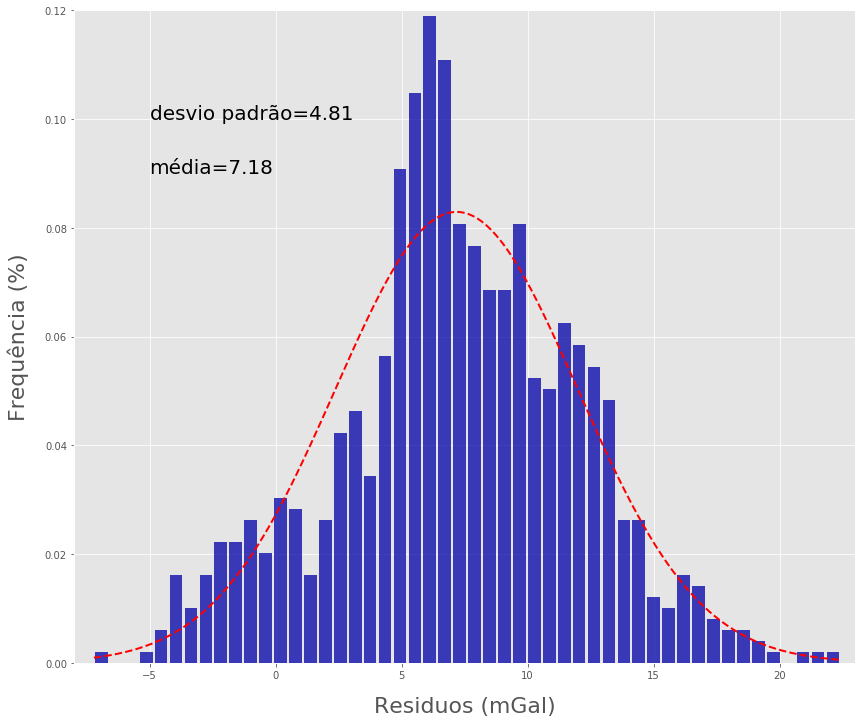

In [48]:
fig = plt.figure(figsize=(14,12))
plt.style.use('ggplot')

plt.hist(terrestre.residuos, bins=50, density=True,color='#0504aa', alpha=0.77, rwidth=0.85)
plt.xlim(-8,23)
plt.ylim(0,0.12)
x = np.linspace(vmin,vmax, ndat,endpoint=True)
y = norm.pdf(x, np.mean(terrestre.residuos), np.std(terrestre.residuos))

plt.text(-5,0.09,'média='+text_mean,fontsize=20)
plt.text(-5,0.10,'desvio padrão='+text_std,fontsize=20)
plt.xlabel('Residuos (mGal)' , fontsize = 22, labelpad = 16)
plt.ylabel('Frequência (%)', fontsize = 22, labelpad = 16)
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.plot(x, y, '--r', linewidth=2)
#plt.title('Histograma dos residuos ', fontsize=20, y=1.02)

plt.savefig('imagens/histograma_residuos_delta.png',format='png', dpi=300, bbox_inches='tight')
plt.show()